In [1]:
from Models import Get_data as Gd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Models.CAE import Encoder, Decoder, Autoencoder
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from tqdm import tqdm
import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)

In [3]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [4]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# CAE

## Create Dataset for CAE

### Use all the case

In [5]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [6]:
train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
train_tensor_set = Gd.MyDataset(train_tensor)

In [7]:
val_tensor = torch.tensor(val_np, dtype=torch.float).permute(0, 2, 1)
val_tensor_set = Gd.MyDataset(val_tensor)

In [8]:
train_loader = DataLoader(train_tensor_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_tensor_set, batch_size=5, shuffle=True)

In [9]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.concat((train_tensor, val_tensor), axis=0))
preprocessor.mean

tensor(6.9571)

### Test set

In [10]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)

In [11]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


In [12]:
test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)
test_tensor_set = Gd.MyDataset(test_tensor)

## Model Info

In [13]:
latent_space = 20

In [14]:
# Create an instance of the model
encoder = Encoder(1, latent_space)
summary(encoder, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 20]                  --
├─Conv1d: 1-1                            [10, 4, 97149]            36
├─Dropout: 1-2                           [10, 4, 97149]            --
├─MaxPool1d: 1-3                         [10, 4, 19429]            --
├─Conv1d: 1-4                            [10, 4, 19429]            132
├─Dropout: 1-5                           [10, 4, 19429]            --
├─MaxPool1d: 1-6                         [10, 4, 3885]             --
├─Conv1d: 1-7                            [10, 1, 3885]             33
├─LeakyReLU: 1-8                         [10, 1, 3885]             --
├─Dropout: 1-9                           [10, 1, 3885]             --
├─MaxPool1d: 1-10                        [10, 1, 777]              --
├─AdaptiveAvgPool1d: 1-11                [10, 1, 1000]             --
├─Flatten: 1-12                          [10, 1000]                --
├─Linear: 1-13

In [15]:
decoder = Decoder(latent_space, 1)
summary(decoder, input_size=(10, latent_space))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 1, 97149]            --
├─Linear: 1-1                            [10, 512]                 10,752
├─Upsample: 1-2                          [10, 1, 1024]             --
├─Conv1d: 1-3                            [10, 1, 1018]             9
├─Linear: 1-4                            [10, 1, 97149]            98,994,831
├─Conv1d: 1-5                            [10, 1, 97149]            2
├─LeakyReLU: 1-6                         [10, 1, 97149]            --
Total params: 99,005,594
Trainable params: 99,005,594
Non-trainable params: 0
Total mult-adds (M): 992.09
Input size (MB): 0.00
Forward/backward pass size (MB): 15.67
Params size (MB): 396.02
Estimated Total Size (MB): 411.69

In [16]:
model = Autoencoder(1, latent_space)
summary(model, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [10, 1, 97149]            --
├─Encoder: 1-1                           [10, 20]                  --
│    └─Conv1d: 2-1                       [10, 4, 97149]            36
│    └─Dropout: 2-2                      [10, 4, 97149]            --
│    └─MaxPool1d: 2-3                    [10, 4, 19429]            --
│    └─Conv1d: 2-4                       [10, 4, 19429]            132
│    └─Dropout: 2-5                      [10, 4, 19429]            --
│    └─MaxPool1d: 2-6                    [10, 4, 3885]             --
│    └─Conv1d: 2-7                       [10, 1, 3885]             33
│    └─LeakyReLU: 2-8                    [10, 1, 3885]             --
│    └─Dropout: 2-9                      [10, 1, 3885]             --
│    └─MaxPool1d: 2-10                   [10, 1, 777]              --
│    └─AdaptiveAvgPool1d: 2-11           [10, 1, 1000]             --
│    └─Flatten

## Train CAE

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [18]:
def train(model, train_loader, val_loader, criterion, optimizer, metric_train, metric_val, device,scheduler=None, epochs=30):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []
    
    min_loss = 10000

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_loader):
            input = preprocessor.transform(x).to(device)
            x = x.to(device)
            optimizer.zero_grad()
            predict= model(input)
            loss = criterion(input, predict)
            loss.backward()
            optimizer.step()
            
            train_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
            relative_train_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

        if scheduler != None:
            scheduler.step()
        # print(train_loss, relative_train_loss, len(train_loader))
        train_loss /= len(train_loader)
        relative_train_loss /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        relative_val_loss = 0
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_loader:
                input = preprocessor.transform(x).to(device)
                x = x.to(device)
                predict= model(input)

                val_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
                relative_val_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

            val_loss /= len(val_loader)
            relative_val_loss /= len(val_loader)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        
        if min_loss >= relative_val_loss:
            min_loss = relative_val_loss
            torch.save(model.state_dict(), 'CAE.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [19]:
model = Autoencoder(1, latent_space).to(device)
optimizer = optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)

## SCHEDULER

criterion = RMSELoss()
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)

train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         metric_train,
                                                                                         metric_val,
                                                                                         device,
                                                                                         scheduler = None,
                                                                                         epochs=50)

100%|██████████| 464/464 [00:24<00:00, 18.65it/s]


Epoch 1/50, train Loss: 5.827128699113583, NRMSE_train_loss: 0.11199395212441168, val Loss: 3.743518214801262, NRMSE_val_loss: 0.07194819632146893


100%|██████████| 464/464 [00:25<00:00, 18.44it/s]


Epoch 2/50, train Loss: 2.955619880351527, NRMSE_train_loss: 0.056805258359888505, val Loss: 2.864209916057258, NRMSE_val_loss: 0.055048413157206155


100%|██████████| 464/464 [00:25<00:00, 18.55it/s]


Epoch 3/50, train Loss: 2.1700614369634925, NRMSE_train_loss: 0.041707291713401935, val Loss: 2.5060829951845367, NRMSE_val_loss: 0.0481654264610903


100%|██████████| 464/464 [00:25<00:00, 18.49it/s]


Epoch 4/50, train Loss: 1.842813000725261, NRMSE_train_loss: 0.03541777116760354, val Loss: 2.4496855519968888, NRMSE_val_loss: 0.04708150125526149


100%|██████████| 464/464 [00:25<00:00, 18.53it/s]


Epoch 5/50, train Loss: 1.635513072512273, NRMSE_train_loss: 0.03143358966014508, val Loss: 2.221571652026012, NRMSE_val_loss: 0.04269728738943051


100%|██████████| 464/464 [00:25<00:00, 18.46it/s]


Epoch 6/50, train Loss: 1.5504571225108772, NRMSE_train_loss: 0.029798864890773106, val Loss: 2.3769169141506326, NRMSE_val_loss: 0.04568293119042084


100%|██████████| 464/464 [00:24<00:00, 18.69it/s]


Epoch 7/50, train Loss: 1.451327268676511, NRMSE_train_loss: 0.02789364799311192, val Loss: 2.278518007747058, NRMSE_val_loss: 0.04379176264949914


100%|██████████| 464/464 [00:25<00:00, 18.50it/s]


Epoch 8/50, train Loss: 1.3382505522719745, NRMSE_train_loss: 0.02572038065610004, val Loss: 2.213459803112622, NRMSE_val_loss: 0.0425413826095133


100%|██████████| 464/464 [00:24<00:00, 18.59it/s]


Epoch 9/50, train Loss: 1.3275361221669049, NRMSE_train_loss: 0.025514455632595665, val Loss: 2.339483544744294, NRMSE_val_loss: 0.044963483891353524


100%|██████████| 464/464 [00:24<00:00, 18.64it/s]


Epoch 10/50, train Loss: 1.238137407421038, NRMSE_train_loss: 0.02379626548519872, val Loss: 2.0852306577666053, NRMSE_val_loss: 0.04007689457322503


100%|██████████| 464/464 [00:23<00:00, 19.43it/s]


Epoch 11/50, train Loss: 1.2080571693849975, NRMSE_train_loss: 0.02321814114613266, val Loss: 1.9612700507558625, NRMSE_val_loss: 0.0376944453134362


100%|██████████| 464/464 [00:24<00:00, 19.29it/s]


Epoch 12/50, train Loss: 1.163416300482791, NRMSE_train_loss: 0.022360170183799648, val Loss: 1.7548046810873623, NRMSE_val_loss: 0.033726303500990415


100%|██████████| 464/464 [00:23<00:00, 19.38it/s]


Epoch 13/50, train Loss: 1.1249510721656784, NRMSE_train_loss: 0.02162089130383563, val Loss: 1.9942238690524265, NRMSE_val_loss: 0.0383277980707072


100%|██████████| 464/464 [00:24<00:00, 19.28it/s]


Epoch 14/50, train Loss: 1.1229141113059273, NRMSE_train_loss: 0.021581742147802663, val Loss: 1.9188411790749123, NRMSE_val_loss: 0.036878987568719636


100%|██████████| 464/464 [00:22<00:00, 20.39it/s]


Epoch 15/50, train Loss: 1.0484148870254386, NRMSE_train_loss: 0.02014991134838683, val Loss: 1.7984233899363156, NRMSE_val_loss: 0.03456462914894881


100%|██████████| 464/464 [00:22<00:00, 20.61it/s]


Epoch 16/50, train Loss: 1.0153076757901702, NRMSE_train_loss: 0.01951361038714069, val Loss: 1.9617846536225285, NRMSE_val_loss: 0.03770433550957462


100%|██████████| 464/464 [00:22<00:00, 20.30it/s]


Epoch 17/50, train Loss: 1.0248950891967477, NRMSE_train_loss: 0.019697874736297746, val Loss: 1.8917905842435772, NRMSE_val_loss: 0.03635909128934145


100%|██████████| 464/464 [00:24<00:00, 19.14it/s]


Epoch 18/50, train Loss: 1.0006500233350129, NRMSE_train_loss: 0.019231899013212914, val Loss: 1.9319048965799397, NRMSE_val_loss: 0.03713006460396894


100%|██████████| 464/464 [00:22<00:00, 20.70it/s]


Epoch 19/50, train Loss: 0.9541167248168896, NRMSE_train_loss: 0.018337556640697836, val Loss: 1.9212371573365967, NRMSE_val_loss: 0.036925036845536066


100%|██████████| 464/464 [00:22<00:00, 20.64it/s]


Epoch 20/50, train Loss: 0.9578694444278191, NRMSE_train_loss: 0.018409681705163855, val Loss: 1.8273320352209026, NRMSE_val_loss: 0.035120236061128046


100%|██████████| 464/464 [00:22<00:00, 20.64it/s]


Epoch 21/50, train Loss: 0.9198202476676168, NRMSE_train_loss: 0.01767839871925013, val Loss: 1.7976581742023598, NRMSE_val_loss: 0.03454992212033991


100%|██████████| 464/464 [00:22<00:00, 20.38it/s]


Epoch 22/50, train Loss: 0.9560149046752987, NRMSE_train_loss: 0.01837403854106328, val Loss: 1.8584925501511014, NRMSE_val_loss: 0.035719122801875246


100%|██████████| 464/464 [00:23<00:00, 19.90it/s]


Epoch 23/50, train Loss: 0.929594241403814, NRMSE_train_loss: 0.017866249091859007, val Loss: 1.8257427698579327, NRMSE_val_loss: 0.035089691522820245


100%|██████████| 464/464 [00:24<00:00, 19.30it/s]


Epoch 24/50, train Loss: 0.9086034546509899, NRMSE_train_loss: 0.017462818636478663, val Loss: 1.974090827950116, NRMSE_val_loss: 0.03794085298632753


100%|██████████| 464/464 [00:23<00:00, 19.62it/s]


Epoch 25/50, train Loss: 0.8824819874275347, NRMSE_train_loss: 0.016960779530124676, val Loss: 1.8898311514278938, NRMSE_val_loss: 0.03632143224942787


100%|██████████| 464/464 [00:22<00:00, 20.65it/s]


Epoch 26/50, train Loss: 0.8935215887453022, NRMSE_train_loss: 0.017172954143586987, val Loss: 1.7812142700984561, NRMSE_val_loss: 0.03423388016506516


100%|██████████| 464/464 [00:22<00:00, 20.52it/s]


Epoch 27/50, train Loss: 0.8731496345637173, NRMSE_train_loss: 0.016781417276621958, val Loss: 2.0147293538882813, NRMSE_val_loss: 0.03872190128433807


100%|██████████| 464/464 [00:22<00:00, 20.49it/s]


Epoch 28/50, train Loss: 0.8492454715586942, NRMSE_train_loss: 0.016321993463046462, val Loss: 1.9280084124926864, NRMSE_val_loss: 0.03705517653825468


100%|██████████| 464/464 [00:22<00:00, 20.69it/s]


Epoch 29/50, train Loss: 0.8352414305353987, NRMSE_train_loss: 0.016052844089150815, val Loss: 1.9051298560767338, NRMSE_val_loss: 0.03661546396926559


100%|██████████| 464/464 [00:22<00:00, 20.48it/s]


Epoch 30/50, train Loss: 0.8294405754141766, NRMSE_train_loss: 0.01594135510847615, val Loss: 2.048114317244497, NRMSE_val_loss: 0.03936354058056042


100%|██████████| 464/464 [00:22<00:00, 20.59it/s]


Epoch 31/50, train Loss: 0.8280218021366103, NRMSE_train_loss: 0.015914087169723392, val Loss: 1.9779190749957645, NRMSE_val_loss: 0.03801442973379945


100%|██████████| 464/464 [00:22<00:00, 20.66it/s]


Epoch 32/50, train Loss: 0.7962418244188202, NRMSE_train_loss: 0.015303294868850759, val Loss: 1.794212900359055, NRMSE_val_loss: 0.0344837060487219


100%|██████████| 464/464 [00:22<00:00, 20.57it/s]


Epoch 33/50, train Loss: 0.8250168551658762, NRMSE_train_loss: 0.015856333864764472, val Loss: 1.8477704237247337, NRMSE_val_loss: 0.03551304992288351


100%|██████████| 464/464 [00:22<00:00, 20.61it/s]


Epoch 34/50, train Loss: 0.7803777426095873, NRMSE_train_loss: 0.014998396614702932, val Loss: 1.6798621344155278, NRMSE_val_loss: 0.03228595221800537


100%|██████████| 464/464 [00:23<00:00, 19.51it/s]


Epoch 35/50, train Loss: 0.8155602485840691, NRMSE_train_loss: 0.015674583499464368, val Loss: 1.7696048555703, NRMSE_val_loss: 0.03401075417561264


100%|██████████| 464/464 [00:22<00:00, 20.68it/s]


Epoch 36/50, train Loss: 0.7940991391781075, NRMSE_train_loss: 0.015262113759647412, val Loss: 1.9370055208946098, NRMSE_val_loss: 0.03722809558605839


100%|██████████| 464/464 [00:23<00:00, 20.06it/s]


Epoch 37/50, train Loss: 0.7753205458665716, NRMSE_train_loss: 0.014901200305381468, val Loss: 1.717281628271629, NRMSE_val_loss: 0.03300513267709777


100%|██████████| 464/464 [00:23<00:00, 19.84it/s]


Epoch 38/50, train Loss: 0.8032002630161827, NRMSE_train_loss: 0.01543703192146495, val Loss: 2.038239812028819, NRMSE_val_loss: 0.03917375828364286


100%|██████████| 464/464 [00:23<00:00, 19.74it/s]


Epoch 39/50, train Loss: 0.7650484657878506, NRMSE_train_loss: 0.014703777046665421, val Loss: 1.9313123709168927, NRMSE_val_loss: 0.03711867634335469


100%|██████████| 464/464 [00:22<00:00, 20.88it/s]


Epoch 40/50, train Loss: 0.7665717350640173, NRMSE_train_loss: 0.014733053344414281, val Loss: 1.6125029099398647, NRMSE_val_loss: 0.030991348036532772


100%|██████████| 464/464 [00:22<00:00, 20.34it/s]


Epoch 41/50, train Loss: 0.7584147705728638, NRMSE_train_loss: 0.014576281354650212, val Loss: 2.0017422242411254, NRMSE_val_loss: 0.03847229652556366


100%|██████████| 464/464 [00:24<00:00, 19.27it/s]


Epoch 42/50, train Loss: 0.7625160667531449, NRMSE_train_loss: 0.014655105825834748, val Loss: 1.7757762906880215, NRMSE_val_loss: 0.03412936542761223


100%|██████████| 464/464 [00:22<00:00, 20.51it/s]


Epoch 43/50, train Loss: 0.7907657940582983, NRMSE_train_loss: 0.015198048799306732, val Loss: 1.819966971874237, NRMSE_val_loss: 0.03497868408609567


100%|██████████| 464/464 [00:22<00:00, 20.25it/s]


Epoch 44/50, train Loss: 0.7078451907326435, NRMSE_train_loss: 0.013604364072871876, val Loss: 1.8656199327830612, NRMSE_val_loss: 0.03585610676813742


100%|██████████| 464/464 [00:23<00:00, 19.64it/s]


Epoch 45/50, train Loss: 0.718199714375981, NRMSE_train_loss: 0.013803371862540471, val Loss: 1.721194106957008, NRMSE_val_loss: 0.03308032833617823


100%|██████████| 464/464 [00:25<00:00, 18.50it/s]


Epoch 46/50, train Loss: 0.7348840890516495, NRMSE_train_loss: 0.014124035614478433, val Loss: 2.0438044841947227, NRMSE_val_loss: 0.039280708365399264


100%|██████████| 464/464 [00:24<00:00, 19.18it/s]


Epoch 47/50, train Loss: 0.7341987138035996, NRMSE_train_loss: 0.01411086312045568, val Loss: 1.6315537876096264, NRMSE_val_loss: 0.031357494520087695


100%|██████████| 464/464 [00:24<00:00, 19.19it/s]


Epoch 48/50, train Loss: 0.7295703987494625, NRMSE_train_loss: 0.014021909669250378, val Loss: 1.9399237499154847, NRMSE_val_loss: 0.03728418206346446


100%|██████████| 464/464 [00:22<00:00, 21.07it/s]


Epoch 49/50, train Loss: 0.6878826458906305, NRMSE_train_loss: 0.013220695844963836, val Loss: 1.7499592705019589, NRMSE_val_loss: 0.03363317747375574


100%|██████████| 464/464 [00:22<00:00, 20.42it/s]


Epoch 50/50, train Loss: 0.703037005367464, NRMSE_train_loss: 0.013511953609473682, val Loss: 1.924293243679507, NRMSE_val_loss: 0.03698377282326591


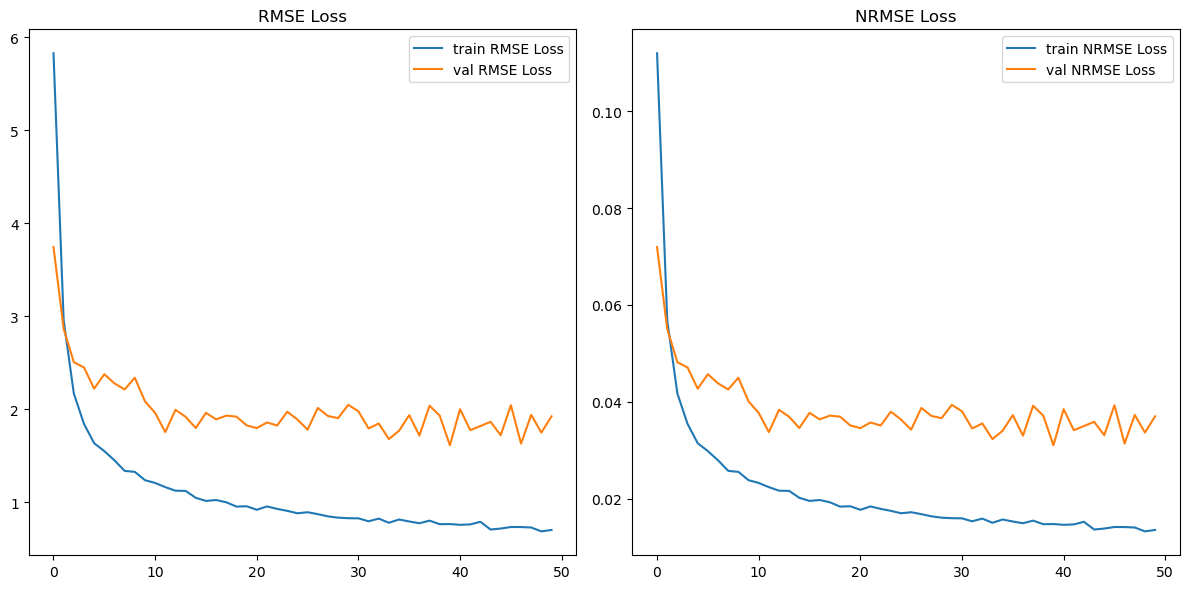

In [20]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.show()


## Result

In [21]:
def draw_pic(x, y, coords):
    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()


In [22]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)

In [23]:
model = Autoencoder(1, latent_space)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
model.load_state_dict(state_dict)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=1000)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=1000, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=20, out_features=512, bias=True)

In [24]:
test_tensor = test_tensor.to(device)
input = preprocessor.transform(test_tensor)
y = model(input)
y = preprocessor.inverse_transform(y)
criterion = RMSELoss()
metric = NRMSE(test_tensor)

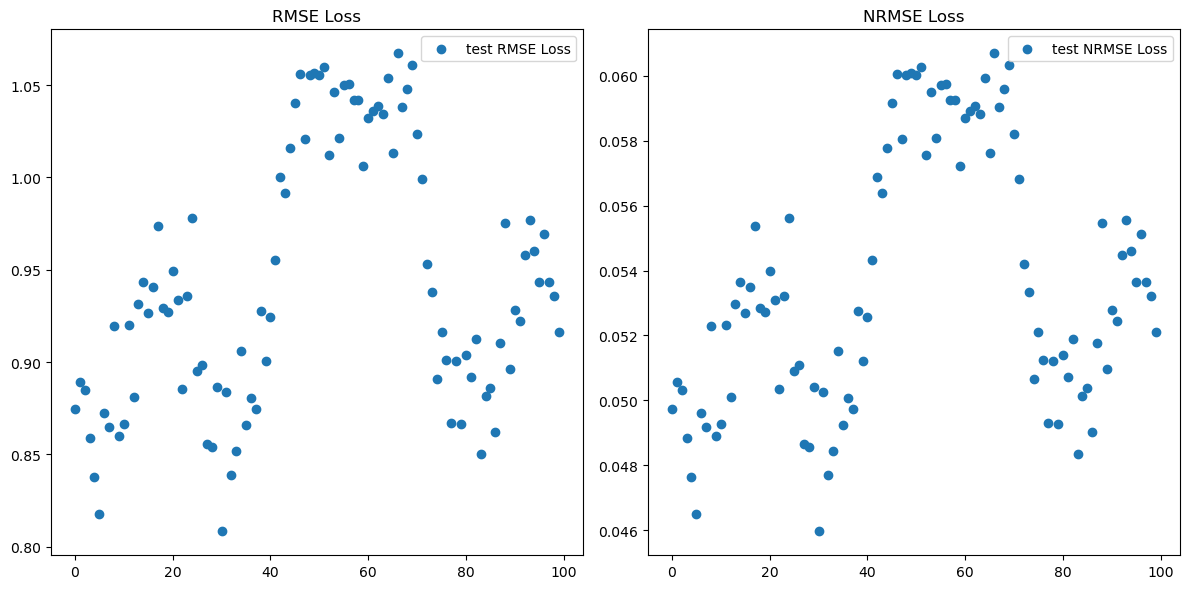

In [25]:
test_rmse=[]
test_nrmse=[]
for i in range(len(test_tensor)):
    nrmse = metric(test_tensor[i], y[i])
    rmse = criterion(test_tensor[i], y[i])

    test_rmse.append(rmse.cpu().detach().numpy())
    test_nrmse.append(nrmse.cpu().detach().numpy())


x = np.arange(0, 100)
test_rmse = np.array(test_rmse)
test_nrmse = np.array(test_nrmse)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_rmse)
np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式

plt.show()

In [26]:
y_np = y[:5].cpu().detach().numpy()
x_np = test_tensor[:5].cpu().detach().numpy()
rmse = criterion(test_tensor, y).item()
nrmse = metric(test_tensor, y).item()
print(f"Ave RMSE test loss: {rmse}")
print(f"Ave NRMSE test loss: {nrmse}")

Ave RMSE test loss: 0.9459303021430969
Ave NRMSE test loss: 0.05379261076450348


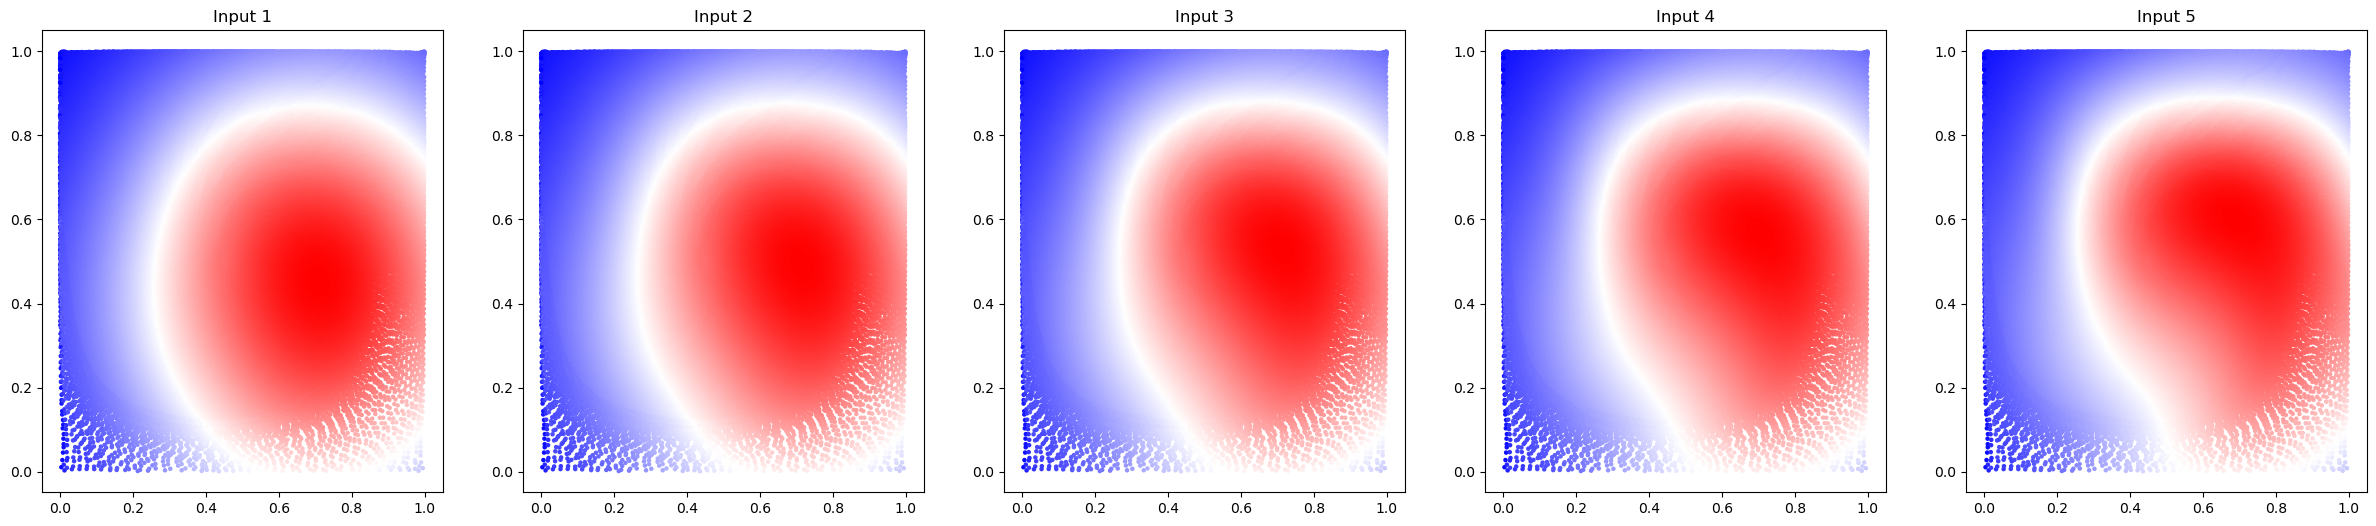

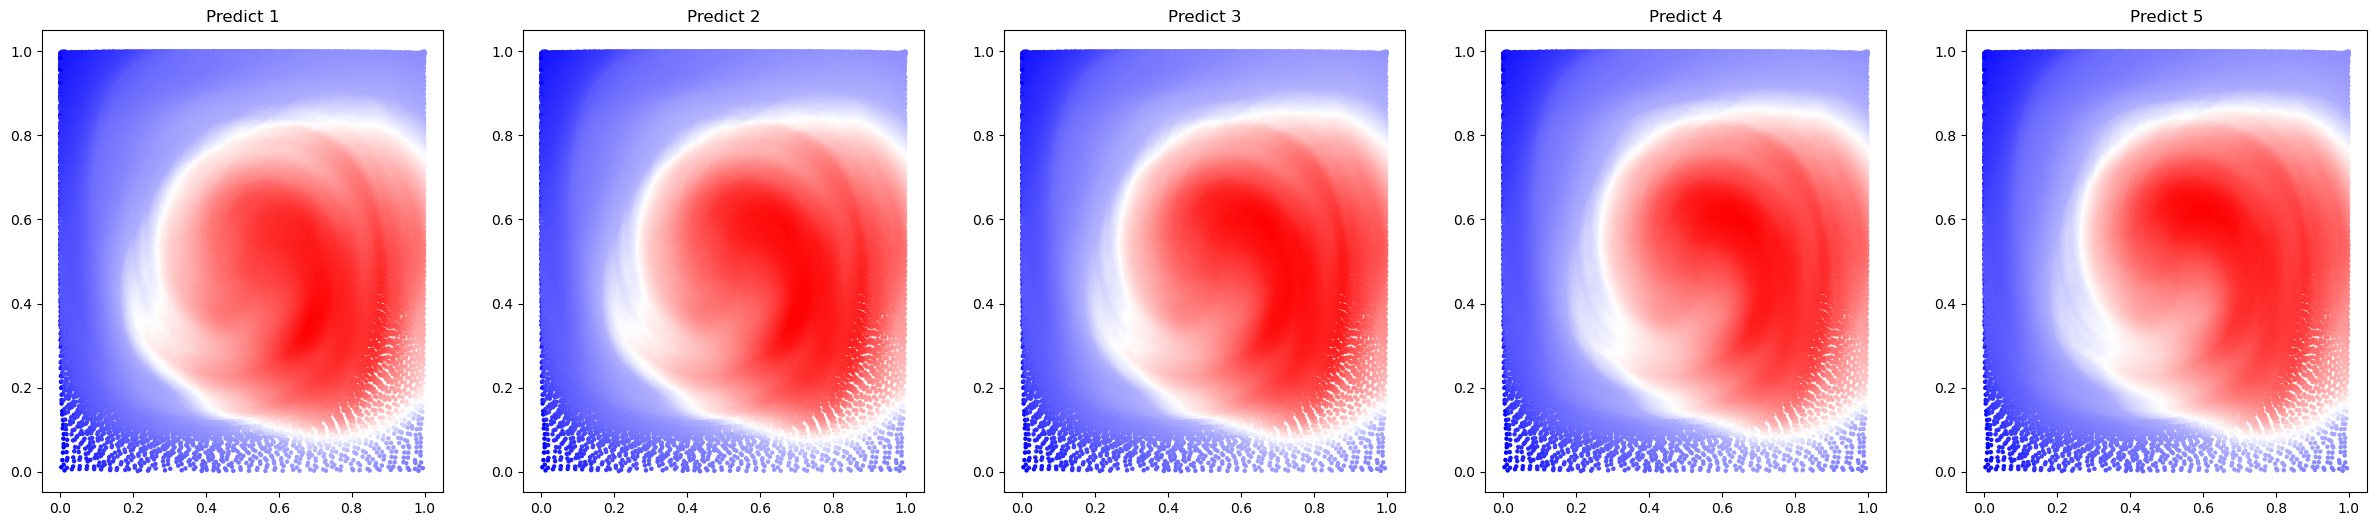

In [27]:
draw_pic(x_np, y_np, xycoords_check)